Training nn to learn sobel filter

In [1]:
import os
import random
import shutil
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [2]:
def apply_sobel_filter(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)  
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)  
    sobel_combined = np.sqrt(sobel_x**2 + sobel_y**2)  
    return sobel_combined

In [3]:
parent_folder = "/kaggle/input/natural-images/natural_images"
output_folder = "/kaggle/working/"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [4]:
original_images = []
sobel_images = []

In [5]:
for class_folder in os.listdir(parent_folder):
    class_path = os.path.join(parent_folder, class_folder)
    if os.path.isdir(class_path):
        all_images = os.listdir(class_path)
        
        output_class_folder = os.path.join(output_folder, class_folder)
        if not os.path.exists(output_class_folder):
            os.makedirs(output_class_folder)
        
        for image_name in all_images:
            src_image_path = os.path.join(class_path, image_name)
            image = cv2.imread(src_image_path)
            
            sobel_image = apply_sobel_filter(image)
            
            image_resized = cv2.resize(image, (128, 128))
            sobel_resized = cv2.resize(sobel_image, (128, 128))
            
            image_resized = image_resized.astype('float32') / 255.0
            sobel_resized = sobel_resized.astype('float32') / 255.0
            
            original_images.append(image_resized)
            sobel_images.append(sobel_resized)
            
            dst_image_path = os.path.join(output_class_folder, image_name)
            cv2.imwrite(dst_image_path, image)
            sobel_image_path = os.path.join(output_class_folder, "sobel_" + image_name)
            cv2.imwrite(sobel_image_path, sobel_image)

print("Images processed and data prepared.")

original_images = np.array(original_images)
sobel_images = np.array(sobel_images)


indices = np.arange(original_images.shape[0])
np.random.shuffle(indices)
original_images = original_images[indices]
sobel_images = sobel_images[indices]


Images processed and data prepared.


In [6]:
sobel_images = np.expand_dims(sobel_images, axis=-1)

from sklearn.model_selection import train_test_split
train_images, test_images, train_sobel_images, test_sobel_images = train_test_split(
    original_images, sobel_images, test_size=0.2, random_state=42)

train_images.shape, test_images.shape, train_sobel_images.shape

((5519, 128, 128, 3), (1380, 128, 128, 3), (5519, 128, 128, 1))

In [7]:
def create_sobel_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(1, (3, 3), activation='linear', padding='same'))
    return model

In [8]:
model = create_sobel_model(input_shape=(128, 128, 3))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 1)    │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,297 (153.50 KB)

 Trainable params: 39,297 (153.50 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(train_images, train_sobel_images, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20


I0000 00:00:1726124403.034019      72 service.cc:145] XLA service 0x7d8a500481f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726124403.034077      72 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1726124403.034081      72 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  5/138 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.2947

I0000 00:00:1726124410.077259      72 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


138/138 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - loss: 0.1318 - val_loss: 0.0434
Epoch 2/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0434 - val_loss: 0.0387
Epoch 3/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0406 - val_loss: 0.0370
Epoch 4/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0383 - val_loss: 0.0363
Epoch 5/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0386 - val_loss: 0.0347
Epoch 6/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0368 - val_loss: 0.0344
Epoch 7/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0358 - val_loss: 0.0340
Epoch 8/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0357 - val_loss: 0.0342
Epoch 9/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0349 - val_loss: 0.0346
Epoch 10/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0351 - val_loss: 0.0395
Epoch 11/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0354 - val_loss: 0.0359
Epoch 12/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/st

In [10]:
model.evaluate(test_images, test_sobel_images)

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0322


0.032183803617954254

In [11]:
def visualize_results(original_image, sobel_image, predicted_image):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original_image, cmap='gray')
    plt.subplot(1, 3, 2)
    plt.title("Sobel Filtered Image")
    plt.imshow(sobel_image, cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title("Predicted Image")
    plt.imshow(predicted_image, cmap='gray')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


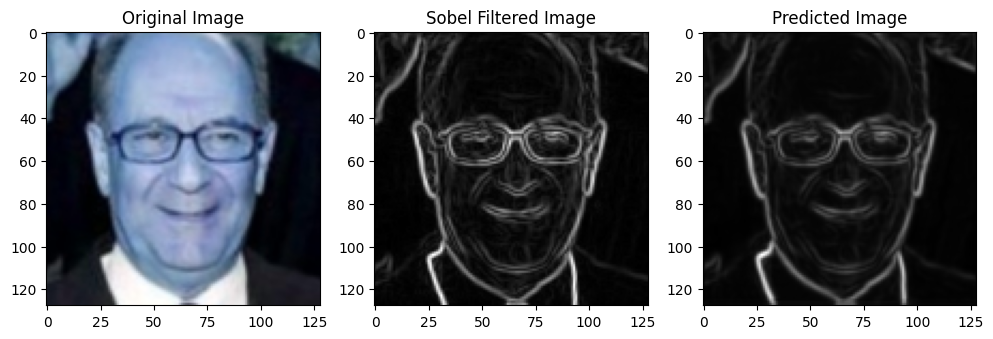

In [12]:
index = 0
predicted_sobel_image = model.predict(np.expand_dims(test_images[index], axis=0))[0]
visualize_results(test_images[index], test_sobel_images[index], predicted_sobel_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


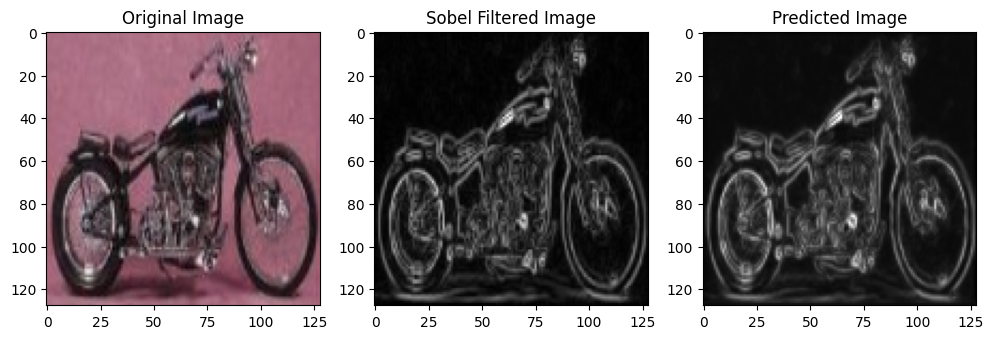

In [13]:
index = 799
predicted_sobel_image = model.predict(np.expand_dims(test_images[index], axis=0))[0]
visualize_results(test_images[index], test_sobel_images[index], predicted_sobel_image)